In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

from scipy.signal import savgol_filter

from modes_func import *
from definition.defPrincipal import *

In [2]:
def adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='m', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )
        return ds
    

def addGrille(ds):
    # On récupère la liste des fichiers à ouvrir via le fichier liste 
    path = "../"
    gridname = path+'gigatl3_grid.nc'
    gridname = path+'GIGATL6_12h_inst_2004-01-15-2004-01-19.nc'
    gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
    ds['hc'] = gd.hc
    ds['h'] = gd.h
    # ds['Vtransform'] = gd.Vtransform
    ds['sc_r'] = gd.sc_r
    ds['sc_w'] = gd.sc_w
    ds['Cs_r'] = gd.Cs_r
    ds['Cs_w'] = gd.Cs_w
    ds['angle'] = gd.angle
    ds['mask_rho'] = gd.mask_rho

    # On modifie des dimensions et des coordonnées, on crée la grille xgcm
    ds = adjust_grid(ds)
    L = ds.dims['x_rho']
    M = ds.dims['y_rho']
    N = ds.dims['s_rho']

    # On crée la grille xgcm
    ds = xgcm_grid(ds)
    grid = ds.attrs['xgcm-Grid']
    return ds, grid

    
def xgcm_grid(ds):
        # Create xgcm grid
        coords={'xi':{'center':'x_rho', 'inner':'x_u'}, 
                'eta':{'center':'y_rho', 'inner':'y_v'}, 
                's':{'center':'s_rho', 'outer':'s_w'}}
        ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords)
        
        return ds

In [14]:
file_mean_4Y = '../bvfDATA/bvf_juil09_23_G6.nc'
ds_4Y = xr.open_dataset(file_mean_4Y)
ds_4Y

<xarray.Dataset>
Dimensions:  (s_rho: 50)
Coordinates:
    eta_rho  float32 ...
    xi_rho   float32 ...
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    eta_w    float32 ...
    xi_w     float32 ...
    z        (s_rho) float64 ...
Data variables:
    bvf      (s_rho) float32 ...

In [15]:
N = (ds_4Y.bvf.values)**(1/2)
z = ds_4Y.z.values
np.flip(N)

array([0.00183751, 0.00257511, 0.00466313, 0.00869075, 0.01447032,
       0.01852219, 0.01921277, 0.01719793, 0.01335422, 0.01061368,
       0.00858628, 0.00613129, 0.00506371, 0.00445393, 0.00531246,
       0.00533868, 0.00469598, 0.00460101, 0.00440346, 0.00386226,
       0.00338295, 0.00328784, 0.00321739, 0.00289842, 0.00273716,
       0.00264895, 0.00246073, 0.00231285, 0.00229313, 0.00222523,
       0.00204442, 0.00193084, 0.00185381, 0.0017697 , 0.00172542,
       0.00168789, 0.00164489, 0.00153231, 0.00137869, 0.00127885,
       0.00123482, 0.00117146, 0.00105469, 0.00095211, 0.00089492,
       0.00086769, 0.00089661, 0.00086033, 0.00072101, 0.00066442],
      dtype=float32)

In [16]:
## Compute vertical eigenmodes

phi,lmbd,zz = SL_chebsolve((N), ((z)), Nmod="auto", Nz="auto", grav=9.80,sm=50, ksplin=3, zbot=None)

modes = phi[1]

eigval = np.real(lmbd)

for i in range(modes.shape[1]):
    modes[:,i]=norm_mode(modes[:,i],zz)


modes[:,0] = np.ones(modes[:,0].shape)

In [17]:
namevar='modes'
modeCDFm = xr.Dataset({namevar:(['wmod','umod'],modes)})
modeCDFm.to_netcdf('modes_G6_mJu.nc')

In [18]:
namevar='lamba'
modeCDF = xr.Dataset({namevar:(['lambda'],eigval)})
modeCDF.to_netcdf('lambda_G6_mJu.nc')

In [19]:
namevar='zz'
modeCDF = xr.Dataset({namevar:(['zz'],zz)})
modeCDF.to_netcdf('zz_6.nc')

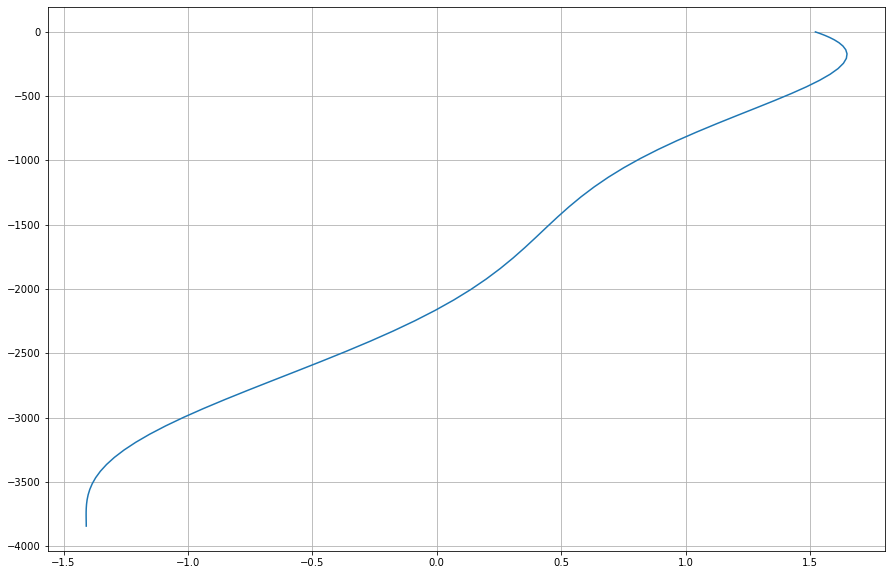

In [21]:
plt.figure(figsize=(15,10))
plt.plot(modes[:,1],(zz))
plt.grid()

In [10]:
eigval

array([0.00418124, 0.02366327, 0.03605424, 0.06106545, 0.07404813,
       0.09905654, 0.11300434, 0.13723922, 0.15219812, 0.17557449,
       0.19147527, 0.21405508, 0.23078113, 0.25267063, 0.27009102,
       0.29140618, 0.30939311, 0.33024477, 0.34868228, 0.36916958,
       0.38795719, 0.40816509, 0.42721865, 0.44721762, 0.46646852,
       0.48631546, 0.50570914, 0.52544879, 0.54494287, 0.5646097 ,
       0.5841719 , 0.60379102, 0.6233988 , 0.6429949 , 0.66260544,
       0.68211276, 0.70189808])

In [11]:
1/eigval

array([239.16356044,  42.25958507,  27.735989  ,  16.37587323,
        13.50473056,  10.09524411,   8.84921762,   7.2865466 ,
         6.57038349,   5.69558824,   5.22260665,   4.67169487,
         4.3331099 ,   3.95772153,   3.70245554,   3.43163616,
         3.23213402,   3.028057  ,   2.86794042,   2.70878224,
         2.57760397,   2.44998904,   2.34072179,   2.23604784,
         2.14376736,   2.05627845,   1.97742126,   1.90313502,
         1.83505475,   1.77113501,   1.71182488,   1.65620216,
         1.60410959,   1.55522229,   1.50919376,   1.46603327,
         1.42470828])

In [12]:
zz

array([-3.84224514e+03, -3.84051551e+03, -3.83532974e+03, -3.82669718e+03,
       -3.81463338e+03, -3.79916008e+03, -3.78030517e+03, -3.75810262e+03,
       -3.73259244e+03, -3.70382061e+03, -3.67183898e+03, -3.63670517e+03,
       -3.59848250e+03, -3.55723985e+03, -3.51305154e+03, -3.46599721e+03,
       -3.41616165e+03, -3.36363465e+03, -3.30851090e+03, -3.25088970e+03,
       -3.19087492e+03, -3.12857469e+03, -3.06410129e+03, -2.99757090e+03,
       -2.92910341e+03, -2.85882221e+03, -2.78685395e+03, -2.71332832e+03,
       -2.63837781e+03, -2.56213750e+03, -2.48474478e+03, -2.40633910e+03,
       -2.32706177e+03, -2.24705564e+03, -2.16646490e+03, -2.08543477e+03,
       -2.00411127e+03, -1.92264096e+03, -1.84117065e+03, -1.75984715e+03,
       -1.67881702e+03, -1.59822628e+03, -1.51822015e+03, -1.43894282e+03,
       -1.36053715e+03, -1.28314442e+03, -1.20690411e+03, -1.13195360e+03,
       -1.05842797e+03, -9.86459710e+02, -9.16178510e+02, -8.47711023e+02,
       -7.81180632e+02, -

In [13]:
modes[:,1]

array([-1.5987532 , -1.59875475, -1.59877726, -1.59886927, -1.59909528,
       -1.59951238, -1.60014041, -1.60092765, -1.60171537, -1.60220397,
       -1.60192421, -1.60021688, -1.59622387, -1.5888938 , -1.57700446,
       -1.55920371, -1.53406937, -1.50018692, -1.45624216, -1.40112375,
       -1.33402853, -1.25456061, -1.16281425, -1.05943049, -0.9456186 ,
       -0.82313633, -0.69422629, -0.56151103, -0.42785348, -0.29619428,
       -0.16937979, -0.0499963 ,  0.05977529,  0.15827253,  0.2444245 ,
        0.31778203,  0.37850657,  0.4273234 ,  0.46544708,  0.49448844,
        0.5163519 ,  0.53313065,  0.54700494,  0.56014672,  0.57463167,
        0.59235844,  0.6149744 ,  0.64380738,  0.67980424,  0.72347832,
        0.7748697 ,  0.83352344,  0.89849145,  0.96836319,  1.04132847,
        1.11527278,  1.18790156,  1.25688592,  1.3200185 ,  1.37536587,
        1.4214032 ,  1.45711801,  1.48207345,  1.49642566,  1.50089528,
        1.49669813,  1.48544366,  1.46901259,  1.44942537,  1.42